# **Smart-UJ UAQUE**
Este Notebook hace parte del servicio inteligente "perfil grupal" y tiene como principal objetivo la generación de grupos a partir de las carácteristicas de los usuarios, incluyendo sus gustos y preferencias de lectura obtenidos a partir del historial de prestamos de material bibliográfico físico en la biblioteca Alfonso Borrero Cabal S.J.

Para formar estos grupos se realizarán varios acercamientos con diferentes técnicas, algóritmos y aproximaciones a partir de los modelos de recomendación clásicos. Posteriormente, se escogerá el mejor modelo para el sistema de recomendación y los grupos serán exportados al servicio inteligente "Servicio de recomedación UAQUE".

**Integrantes:**</br>
Johan Ortegón </br>
Juan Angarita </br>
Jorge Salgado </br>
Daniel Tibaquira </br></br>
**Directora de Proyecto de Grado:** </br>
Viky Arias </br>


#Importación de datos

# Primero importamos el drive para poder leer los archivos

Estas son las librerias que vamos a usar para hacer el join de ambas tablas y poder hacer las diferentes agrupaciones de estudiantes. 

* pandas(pd): Permite almacenar los datos en dataframes(matrices) y operación entre las celdas.

# Construir la tabla de pesos Dewey por usuario con Cluster

# Usando el modelo ya existente

In [29]:
#importar el Join de tablas
df = pd.read_json('https://www.dropbox.com/s/iu6t55j472jnrx7/joinTablas.json?dl=1')

In [38]:
df_user_cluster = pd.read_json('https://www.dropbox.com/s/fclr4aoy6z2em02/userCluster.json?dl=1')

Anotamos la estructura del archivo. 

In [39]:
print("Numero de filas:", df.shape[0])
print("Numero de columnas:", df.shape[1])

Numero de filas: 489474
Numero de columnas: 21


El clustering para este experimento se realizará sobre el atributo "Signatura" el cual representa el dewey hasta la unidad (dando aproximadamente 900 deweys diferentes). Recordar la diferencia entre la columna "Dewey" y "Signatura". La primera es la que originalmente contiene el dataset de prestamos y solo venía con valores hasta la decena, mientras que "Sginatura" originalmente era una valor que señalaba el dewey especifico del libro y su ubicación al interior de la biblioteca. Se realizo una transformación para obtener únicamente el valor númerico de este valor y así obtener el dewey hasta la unidad(más especifico).

In [40]:
eliminar = df.loc[df["Signatura"].isnull()]
print("Numero de datos sin Dewey(Singatura):" , eliminar.shape[0])

Numero de datos sin Dewey(Singatura): 0


In [41]:
print("Valores de signatura unicos: " , len(df["Signatura"].unique()))
print("Valores de Dewey(decena) unicos: " , len(df["Dewey"].unique()))

Valores de signatura unicos:  756
Valores de Dewey(decena) unicos:  99


A partir del análisis con expertos en negocio, se ha entendido que es importante tomar en cuenta el cambio de gustos de los usuarios a través del tiempo y dar menos peso a prestamos que se realizaron en el pasado a prestamos más recientes. Para esto se creará una nueva columna denominada "Peso" la cual determinará el peso quue tiene dicho prestamo.
La disminución del peso será exponencial según la diferencia con el año actual y se calculará con la siguiente formula:

$Peso = \frac{1}{2^{(2021-20xx)}}$


In [42]:
df["Peso"] = df.apply(lambda row: 1/2**(2021-row.Year), axis=1 )

In [43]:
df.columns

Index(['RowID', 'Fecha', 'IDItem', 'NumeroUbicacion', 'Dewey', 'Ubicacion',
       'Llave', 'Programa', 'Facultad', 'IDUsuario', 'Year', 'Signatura',
       'TipoItem', 'Autor', 'Titulo', 'AnioPublicacion', 'DeweyEspecifico',
       'TemaDewey', 'Temas', 'Union', 'Peso'],
      dtype='object')

Se creará una nueva tabla donde únicamente se van a tener en cuenta los deweys que le gustan a cada usuario así como los atributos para posteriormente realizar el clustering. 

In [45]:
pesos_usuarios = pd.DataFrame(columns= df["Signatura"].unique(),dtype=float)
tam = len(df["Signatura"].unique())
pesos_usuarios.columns = pesos_usuarios.columns.astype(str)
display(pesos_usuarios)

ids = df["IDUsuario"].unique()
i = 0
for usuario in ids:
  pesos_usuarios.loc[i] = np.zeros((tam,), dtype=int)
  #Para cada usuario traer sus Deweys y sus pesas asociados
  prestamos = df.loc[df["IDUsuario"]==usuario]
  deweys = prestamos[["Signatura","Peso"]]
  result_user = deweys.groupby("Signatura")["Peso"].sum().reset_index(name="Peso")
  # Recorrer los Deweys y Pesos para plasmarlos en una matriz
  #display(result_user)
  for index, row in result_user.iterrows():
    d = row["Signatura"]
    p=row['Peso']
    pesos_usuarios[d][i] = p
  i = i+1

,720,540,512,712,741,814,823,330,863,696,620,744,158,943,728,574,724,711,843,745,809,307,690,301,333,R,352,388,131,303,302,305,342,986,861,725,344,701,808,363,692,726,927,759,895,813,428,746,658,332,004,918,686,304,747,153,121,862,370,617,136,629,001,517,926,721,372,612,306,155,455,947,923,616,346,864,150,154,791,111,821,709,704,688,005,891,841,736,727,152,580,822,523,591,937,691,853,811,509,339,869,844,851,133,128,792,881,909,327,922,624,115,242,722,421,410,420,659,006,070,495,371,801,194,262,501,113,930,729,300,338,291,385,331,972,778,910,553,530,520,928,882,581,635,779,770,723,515,568,670,694,640,292,833,739,749,954,646,685,440,335,343,027,839,710,255,985,702,320,577,664,621,743,742,935,379,631,824,625,760,894,345,170,794,983,571,628,892,322,630,531,595,920,350,618,641,867,858,608,781,675,236,666,707,448,193,149,657,398,364,190,751,340,189,391,700,323,380,796,901,780,610,668,925,980,137,378,239,326,182,519,615,457,500,321,271,819,613,946,278,829,940,575,425,373,003,598,896,362,589,677,537,717,757,599,871,348,950,266,636,593,830,695,590,159,438,341,873,883,355,604,786,102,354,508,110,597,334,325,750,915,669,929,614,949,752,714,676,684,860,415,146,907,010,294,611,693,662,160,784,914,982,514,697,365,521,771,584,764,854,229,347,157,269,171,730,215,638,609,132,868,973,516,174,195,117,248,987,849,793,945,220,172,708,511,418,820,826,100,109,951,185,196,401,361,261,852,921,188,601,181,184,836,785,769,735,787,468,299,902,177,493,510,782,984,028,765,235,192,179,776,228,761,789,948,461,866,324,572,884,526,738,120,783,390,534,758,396,445,767,272,970,831,893,475,394,384,536,507,848,126,941,176,788,309,069,465,775,441,576,471,939,135,740,134,547,582,198,897,550,430,233,842,888,297,470,199,241,213,268,227,273,834,898,989,832,875,551,944,880,201,411,763,790,810,469,151,539,180,412,480,211,349,938,200,932,025,464,433,960,802,222,687,936,491,296,731,173,230,191,667,144,498,168,674,336,246,125,650,141,197,232,225,660,382,592,573,632,543,513,541,504,545,522,538,661,596,649,633,542,312,164,079,637,544,535,587,639,387,552,549,375,458,585,588,859,942,663,532,485,487,583,889,952,546,329,226,234,123,634,224,112,178,570,647,956,187,310,311,648,282,368,221,253,270,395,449,231,337,651,407,183,020,377,207,366,376,623,357,981,840,846,212,959,912,622,818,502,293,142,417,804,911,817,101,351,885,353,900,392,467,393,280,953,975,328,916,917,209,107,460,838,435,216,607,400,494,381,402,812,210,285,274,904,186,356,056,850,290,807,529,223,957,367,800,478,974,643,627,251,968,870,318,021,497,865,254,156,856,002,029,404,462,094,252,444,967,828,446,443,116,374,422,934,414,093,429,238,071,958,489,129,413,423,011,492,264,369,284,496,022,026,899,876,023,655,427,104,145,754,955,874,295,482,878,665,681,424,671,389,558,165,218,097,265,281,214,203,130,419,924,877,732,122,815,827,503,358,797,076,247,837,386,872,148,931,962,548,855,719,208,237,913,718,919,961,795,816,963,44O.7,383,525,359,560,933,979,978,887,463,799,533,562,903,825,409,524,642,971,499,439,997,964,567,857,477,279,267,114,034,673,447,600,653,263,091,586


La matriz generada es una matriz dispersa donde todos los valores son ceros excepto donde el usuario haya realizado un prestamo.

In [46]:
pesos_usuarios.shape

(24407, 756)

## Join entre pesos y clusterizacion

In [47]:
display(df_user_cluster)

,IDUsuario,Peso,cluster
0,00063d52cf68c65d2a569e95c40345c4a305ccc7,0.500,26
1,0006b3bdabeaa5389b211c8487bd67d339c97ef7,0.500,152
2,000a0630c32a437052696f6921e3181f155291d0,0.500,152
3,000c040064aedd76057c5309064a3823db970644,0.125,41
4,000f23e62e6d4995ede7090c6447ad6736edc4de,1.500,26
...,...,...,...
24402,fff71390a9f54ced5134452870d70ff18812f05f,2.125,33
24403,fff716c9685b5267e6ecfcdc00e9303509355bc1,1.000,65
24404,fff735f54719b720fc4c6c723208ad1f06e9605e,14.500,152
24405,fffb2be68fef4b27a810b11a641d84052eb02347,0.500,64


In [48]:
pesos_usuarios['IDUsuario'] = ids
display(pesos_usuarios)

,720,540,512,712,741,814,823,330,863,696,620,744,158,943,728,574,724,711,843,745,809,307,690,301,333,R,352,388,131,303,302,305,342,986,861,725,344,701,808,363,692,726,927,759,895,813,428,746,658,332,004,918,686,304,747,153,121,862,370,617,136,629,001,517,926,721,372,612,306,155,455,947,923,616,346,864,150,154,791,111,821,709,704,688,005,891,841,736,727,152,580,822,523,591,937,691,853,811,509,339,869,844,851,133,128,792,881,909,327,922,624,115,242,722,421,410,420,659,006,070,495,371,801,194,262,501,113,930,729,300,338,291,385,331,972,778,910,553,530,520,928,882,581,635,779,770,723,515,568,670,694,640,292,833,739,749,954,646,685,440,335,343,027,839,710,255,985,702,320,577,664,621,743,742,935,379,631,824,625,760,894,345,170,794,983,571,628,892,322,630,531,595,920,350,618,641,867,858,608,781,675,236,666,707,448,193,149,657,398,364,190,751,340,189,391,700,323,380,796,901,780,610,668,925,980,137,378,239,326,182,519,615,457,500,321,271,819,613,946,278,829,940,575,425,373,003,598,896,362,589,677,537,717,757,599,871,348,950,266,636,593,830,695,590,159,438,341,873,883,355,604,786,102,354,508,110,597,334,325,750,915,669,929,614,949,752,714,676,684,860,415,146,907,010,294,611,693,662,160,784,914,982,514,697,365,521,771,584,764,854,229,347,157,269,171,730,215,638,609,132,868,973,516,174,195,117,248,987,849,793,945,220,172,708,511,418,820,826,100,109,951,185,196,401,361,261,852,921,188,601,181,184,836,785,769,735,787,468,299,902,177,493,510,782,984,028,765,235,192,179,776,228,761,789,948,461,866,324,572,884,526,738,120,783,390,534,758,396,445,767,272,970,831,893,475,394,384,536,507,848,126,941,176,788,309,069,465,775,441,576,471,939,135,740,134,547,582,198,897,550,430,233,842,888,297,470,199,241,213,268,227,273,834,898,989,832,875,551,944,880,201,411,763,790,810,469,151,539,180,412,480,211,349,938,200,932,025,464,433,960,802,222,687,936,491,296,731,173,230,191,667,144,498,168,674,336,246,125,650,141,197,232,225,660,382,592,573,632,543,513,541,504,545,522,538,661,596,649,633,542,312,164,079,637,544,535,587,639,387,552,549,375,458,585,588,859,942,663,532,485,487,583,889,952,546,329,226,234,123,634,224,112,178,570,647,956,187,310,311,648,282,368,221,253,270,395,449,231,337,651,407,183,020,377,207,366,376,623,357,981,840,846,212,959,912,622,818,502,293,142,417,804,911,817,101,351,885,353,900,392,467,393,280,953,975,328,916,917,209,107,460,838,435,216,607,400,494,381,402,812,210,285,274,904,186,356,056,850,290,807,529,223,957,367,800,478,974,643,627,251,968,870,318,021,497,865,254,156,856,002,029,404,462,094,252,444,967,828,446,443,116,374,422,934,414,093,429,238,071,958,489,129,413,423,011,492,264,369,284,496,022,026,899,876,023,655,427,104,145,754,955,874,295,482,878,665,681,424,671,389,558,165,218,097,265,281,214,203,130,419,924,877,732,122,815,827,503,358,797,076,247,837,386,872,148,931,962,548,855,719,208,237,913,718,919,961,795,816,963,44O.7,383,525,359,560,933,979,978,887,463,799,533,562,903,825,409,524,642,971,499,439,997,964,567,857,477,279,267,114,034,673,447,600,653,263,091,586,IDUsuario
0,2.00,0.0,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.25,0.0,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.00,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.500,0.0,0.0,0.0,0.0,0.0

In [49]:
join_pesos_cluster_usuario = pd.merge(pesos_usuarios, df_user_cluster, left_on='IDUsuario', right_on='IDUsuario', how='left')
print("pesos size:", pesos_usuarios.shape)
print("cluster size:", df_user_cluster.shape)
print("Join size:", join_pesos_cluster_usuario.shape)
join_pesos_cluster_usuario = join_pesos_cluster_usuario.drop(labels = 'Peso', axis = 1)
display(join_pesos_cluster_usuario)

pesos size: (24407, 757)
cluster size: (24407, 3)
Join size: (24407, 759)


,720,540,512,712,741,814,823,330,863,696,620,744,158,943,728,574,724,711,843,745,809,307,690,301,333,R,352,388,131,303,302,305,342,986,861,725,344,701,808,363,692,726,927,759,895,813,428,746,658,332,004,918,686,304,747,153,121,862,370,617,136,629,001,517,926,721,372,612,306,155,455,947,923,616,346,864,150,154,791,111,821,709,704,688,005,891,841,736,727,152,580,822,523,591,937,691,853,811,509,339,869,844,851,133,128,792,881,909,327,922,624,115,242,722,421,410,420,659,006,070,495,371,801,194,262,501,113,930,729,300,338,291,385,331,972,778,910,553,530,520,928,882,581,635,779,770,723,515,568,670,694,640,292,833,739,749,954,646,685,440,335,343,027,839,710,255,985,702,320,577,664,621,743,742,935,379,631,824,625,760,894,345,170,794,983,571,628,892,322,630,531,595,920,350,618,641,867,858,608,781,675,236,666,707,448,193,149,657,398,364,190,751,340,189,391,700,323,380,796,901,780,610,668,925,980,137,378,239,326,182,519,615,457,500,321,271,819,613,946,278,829,940,575,425,373,003,598,896,362,589,677,537,717,757,599,871,348,950,266,636,593,830,695,590,159,438,341,873,883,355,604,786,102,354,508,110,597,334,325,750,915,669,929,614,949,752,714,676,684,860,415,146,907,010,294,611,693,662,160,784,914,982,514,697,365,521,771,584,764,854,229,347,157,269,171,730,215,638,609,132,868,973,516,174,195,117,248,987,849,793,945,220,172,708,511,418,820,826,100,109,951,185,196,401,361,261,852,921,188,601,181,184,836,785,769,735,787,468,299,902,177,493,510,782,984,028,765,235,192,179,776,228,761,789,948,461,866,324,572,884,526,738,120,783,390,534,758,396,445,767,272,970,831,893,475,394,384,536,507,848,126,941,176,788,309,069,465,775,441,576,471,939,135,740,134,547,582,198,897,550,430,233,842,888,297,470,199,241,213,268,227,273,834,898,989,832,875,551,944,880,201,411,763,790,810,469,151,539,180,412,480,211,349,938,200,932,025,464,433,960,802,222,687,936,491,296,731,173,230,191,667,144,498,168,674,336,246,125,650,141,197,232,225,660,382,592,573,632,543,513,541,504,545,522,538,661,596,649,633,542,312,164,079,637,544,535,587,639,387,552,549,375,458,585,588,859,942,663,532,485,487,583,889,952,546,329,226,234,123,634,224,112,178,570,647,956,187,310,311,648,282,368,221,253,270,395,449,231,337,651,407,183,020,377,207,366,376,623,357,981,840,846,212,959,912,622,818,502,293,142,417,804,911,817,101,351,885,353,900,392,467,393,280,953,975,328,916,917,209,107,460,838,435,216,607,400,494,381,402,812,210,285,274,904,186,356,056,850,290,807,529,223,957,367,800,478,974,643,627,251,968,870,318,021,497,865,254,156,856,002,029,404,462,094,252,444,967,828,446,443,116,374,422,934,414,093,429,238,071,958,489,129,413,423,011,492,264,369,284,496,022,026,899,876,023,655,427,104,145,754,955,874,295,482,878,665,681,424,671,389,558,165,218,097,265,281,214,203,130,419,924,877,732,122,815,827,503,358,797,076,247,837,386,872,148,931,962,548,855,719,208,237,913,718,919,961,795,816,963,44O.7,383,525,359,560,933,979,978,887,463,799,533,562,903,825,409,524,642,971,499,439,997,964,567,857,477,279,267,114,034,673,447,600,653,263,091,586,IDUsuario,cluster
0,2.00,0.0,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.25,0.0,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.00,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.500,0.0,0.0,0.0

# Exportar datos

Exportar la tabla con los Deweys por Usuario con su cluster para ser usada por el dashboard a continuación.

In [50]:
join_pesos_cluster_usuario.to_json('C:/Users/johan/Desktop/GitKraken/DataOutOfGit/Dashboard/pesos_usuario_dewey_unidad.json')

# Importando los datos necesario para producir el DashBoard

In [51]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

In [53]:
pesosUsuarios = pd.read_json('https://www.dropbox.com/s/q0j60basw5sxzun/pesos_usuario_dewey_unidad.json?dl=1')
clusterCentroides = pd.read_json('https://www.dropbox.com/s/21nkndg6ql5wsw9/centroids.json?dl=1')

In [54]:
print(type(pesosUsuarios))
display(pesosUsuarios.loc[pesosUsuarios['IDUsuario'] == '000a0630c32a437052696f6921e3181f155291d0'])

<class 'pandas.core.frame.DataFrame'>


,720,540,512,712,741,814,823,330,863,696,620,744,158,943,728,574,724,711,843,745,809,307,690,301,333,R,352,388,131,303,302,305,342,986,861,725,344,701,808,363,692,726,927,759,895,813,428,746,658,332,004,918,686,304,747,153,121,862,370,617,136,629,001,517,926,721,372,612,306,155,455,947,923,616,346,864,150,154,791,111,821,709,704,688,005,891,841,736,727,152,580,822,523,591,937,691,853,811,509,339,869,844,851,133,128,792,881,909,327,922,624,115,242,722,421,410,420,659,006,070,495,371,801,194,262,501,113,930,729,300,338,291,385,331,972,778,910,553,530,520,928,882,581,635,779,770,723,515,568,670,694,640,292,833,739,749,954,646,685,440,335,343,027,839,710,255,985,702,320,577,664,621,743,742,935,379,631,824,625,760,894,345,170,794,983,571,628,892,322,630,531,595,920,350,618,641,867,858,608,781,675,236,666,707,448,193,149,657,398,364,190,751,340,189,391,700,323,380,796,901,780,610,668,925,980,137,378,239,326,182,519,615,457,500,321,271,819,613,946,278,829,940,575,425,373,003,598,896,362,589,677,537,717,757,599,871,348,950,266,636,593,830,695,590,159,438,341,873,883,355,604,786,102,354,508,110,597,334,325,750,915,669,929,614,949,752,714,676,684,860,415,146,907,010,294,611,693,662,160,784,914,982,514,697,365,521,771,584,764,854,229,347,157,269,171,730,215,638,609,132,868,973,516,174,195,117,248,987,849,793,945,220,172,708,511,418,820,826,100,109,951,185,196,401,361,261,852,921,188,601,181,184,836,785,769,735,787,468,299,902,177,493,510,782,984,028,765,235,192,179,776,228,761,789,948,461,866,324,572,884,526,738,120,783,390,534,758,396,445,767,272,970,831,893,475,394,384,536,507,848,126,941,176,788,309,069,465,775,441,576,471,939,135,740,134,547,582,198,897,550,430,233,842,888,297,470,199,241,213,268,227,273,834,898,989,832,875,551,944,880,201,411,763,790,810,469,151,539,180,412,480,211,349,938,200,932,025,464,433,960,802,222,687,936,491,296,731,173,230,191,667,144,498,168,674,336,246,125,650,141,197,232,225,660,382,592,573,632,543,513,541,504,545,522,538,661,596,649,633,542,312,164,079,637,544,535,587,639,387,552,549,375,458,585,588,859,942,663,532,485,487,583,889,952,546,329,226,234,123,634,224,112,178,570,647,956,187,310,311,648,282,368,221,253,270,395,449,231,337,651,407,183,020,377,207,366,376,623,357,981,840,846,212,959,912,622,818,502,293,142,417,804,911,817,101,351,885,353,900,392,467,393,280,953,975,328,916,917,209,107,460,838,435,216,607,400,494,381,402,812,210,285,274,904,186,356,056,850,290,807,529,223,957,367,800,478,974,643,627,251,968,870,318,021,497,865,254,156,856,002,029,404,462,094,252,444,967,828,446,443,116,374,422,934,414,093,429,238,071,958,489,129,413,423,011,492,264,369,284,496,022,026,899,876,023,655,427,104,145,754,955,874,295,482,878,665,681,424,671,389,558,165,218,097,265,281,214,203,130,419,924,877,732,122,815,827,503,358,797,076,247,837,386,872,148,931,962,548,855,719,208,237,913,718,919,961,795,816,963,44O.7,383,525,359,560,933,979,978,887,463,799,533,562,903,825,409,524,642,971,499,439,997,964,567,857,477,279,267,114,034,673,447,600,653,263,091,586,IDUsuario,cluster
15806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [55]:
pd.set_option('max_columns', 800)
display(pesosUsuarios.loc[pesosUsuarios["cluster"] == 0][:10])
display(clusterCentroides)

,720,540,512,712,741,814,823,330,863,696,620,744,158,943,728,574,724,711,843,745,809,307,690,301,333,R,352,388,131,303,302,305,342,986,861,725,344,701,808,363,692,726,927,759,895,813,428,746,658,332,004,918,686,304,747,153,121,862,370,617,136,629,001,517,926,721,372,612,306,155,455,947,923,616,346,864,150,154,791,111,821,709,704,688,005,891,841,736,727,152,580,822,523,591,937,691,853,811,509,339,869,844,851,133,128,792,881,909,327,922,624,115,242,722,421,410,420,659,006,070,495,371,801,194,262,501,113,930,729,300,338,291,385,331,972,778,910,553,530,520,928,882,581,635,779,770,723,515,568,670,694,640,292,833,739,749,954,646,685,440,335,343,027,839,710,255,985,702,320,577,664,621,743,742,935,379,631,824,625,760,894,345,170,794,983,571,628,892,322,630,531,595,920,350,618,641,867,858,608,781,675,236,666,707,448,193,149,657,398,364,190,751,340,189,391,700,323,380,796,901,780,610,668,925,980,137,378,239,326,182,519,615,457,500,321,271,819,613,946,278,829,940,575,425,373,003,598,896,362,589,677,537,717,757,599,871,348,950,266,636,593,830,695,590,159,438,341,873,883,355,604,786,102,354,508,110,597,334,325,750,915,669,929,614,949,752,714,676,684,860,415,146,907,010,294,611,693,662,160,784,914,982,514,697,365,521,771,584,764,854,229,347,157,269,171,730,215,638,609,132,868,973,516,174,195,117,248,987,849,793,945,220,172,708,511,418,820,826,100,109,951,185,196,401,361,261,852,921,188,601,181,184,836,785,769,735,787,468,299,902,177,493,510,782,984,028,765,235,192,179,776,228,761,789,948,461,866,324,572,884,526,738,120,783,390,534,758,396,445,767,272,970,831,893,475,394,384,536,507,848,126,941,176,788,309,069,465,775,441,576,471,939,135,740,134,547,582,198,897,550,430,233,842,888,297,470,199,241,213,268,227,273,834,898,989,832,875,551,944,880,201,411,763,790,810,469,151,539,180,412,480,211,349,938,200,932,025,464,433,960,802,222,687,936,491,296,731,173,230,191,667,144,498,168,674,336,246,125,650,141,197,232,225,660,382,592,573,632,543,513,541,504,545,522,538,661,596,649,633,542,312,164,079,637,544,535,587,639,387,552,549,375,458,585,588,859,942,663,532,485,487,583,889,952,546,329,226,234,123,634,224,112,178,570,647,956,187,310,311,648,282,368,221,253,270,395,449,231,337,651,407,183,020,377,207,366,376,623,357,981,840,846,212,959,912,622,818,502,293,142,417,804,911,817,101,351,885,353,900,392,467,393,280,953,975,328,916,917,209,107,460,838,435,216,607,400,494,381,402,812,210,285,274,904,186,356,056,850,290,807,529,223,957,367,800,478,974,643,627,251,968,870,318,021,497,865,254,156,856,002,029,404,462,094,252,444,967,828,446,443,116,374,422,934,414,093,429,238,071,958,489,129,413,423,011,492,264,369,284,496,022,026,899,876,023,655,427,104,145,754,955,874,295,482,878,665,681,424,671,389,558,165,218,097,265,281,214,203,130,419,924,877,732,122,815,827,503,358,797,076,247,837,386,872,148,931,962,548,855,719,208,237,913,718,919,961,795,816,963,44O.7,383,525,359,560,933,979,978,887,463,799,533,562,903,825,409,524,642,971,499,439,997,964,567,857,477,279,267,114,034,673,447,600,653,263,091,586,IDUsuario,cluster
7,4.500,0.0,0.0,0.125,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.00,0.0,0.0,0.000,0.0,0.000,1.125,0.0,0.000,0.0,0.0,0.0,0.000,0.00,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.00,0.00,0.0,0.00,0.0,0.875,0.0,0.0,0.0,0.00,0.0,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.25,0.0,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.125,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

,720,540,512,712,741,814,823,330,863,696,620,744,158,943,728,574,724,711,843,745,809,307,690,301,333,R,352,388,131,303,302,305,342,986,861,725,344,701,808,363,692,726,927,759,895,813,428,746,658,332,004,918,686,304,747,153,121,862,370,617,136,629,001,517,926,721,372,612,306,155,455,947,923,616,346,864,150,154,791,111,821,709,704,688,005,891,841,736,727,152,580,822,523,591,937,691,853,811,509,339,869,844,851,133,128,792,881,909,327,922,624,115,242,722,421,410,420,659,006,070,495,371,801,194,262,501,113,930,729,300,338,291,385,331,972,778,910,553,530,520,928,882,581,635,779,770,723,515,568,670,694,640,292,833,739,749,954,646,685,440,335,343,027,839,710,255,985,702,320,577,664,621,743,742,935,379,631,824,625,760,894,345,170,794,983,571,628,892,322,630,531,595,920,350,618,641,867,858,608,781,675,236,666,707,448,193,149,657,398,364,190,751,340,189,391,700,323,380,796,901,780,610,668,925,980,137,378,239,326,182,519,615,457,500,321,271,819,613,946,278,829,940,575,425,373,003,598,896,362,589,677,537,717,757,599,871,348,950,266,636,593,830,695,590,159,438,341,873,883,355,604,786,102,354,508,110,597,334,325,750,915,669,929,614,949,752,714,676,684,860,415,146,907,010,294,611,693,662,160,784,914,982,514,697,365,521,771,584,764,854,229,347,157,269,171,730,215,638,609,132,868,973,516,174,195,117,248,987,849,793,945,220,172,708,511,418,820,826,100,109,951,185,196,401,361,261,852,921,188,601,181,184,836,785,769,735,787,468,299,902,177,493,510,782,984,028,765,235,192,179,776,228,761,789,948,461,866,324,572,884,526,738,120,783,390,534,758,396,445,767,272,970,831,893,475,394,384,536,507,848,126,941,176,788,309,069,465,775,441,576,471,939,135,740,134,547,582,198,897,550,430,233,842,888,297,470,199,241,213,268,227,273,834,898,989,832,875,551,944,880,201,411,763,790,810,469,151,539,180,412,480,211,349,938,200,932,025,464,433,960,802,222,687,936,491,296,731,173,230,191,667,144,498,168,674,336,246,125,650,141,197,232,225,660,382,592,573,632,543,513,541,504,545,522,538,661,596,649,633,542,312,164,079,637,544,535,587,639,387,552,549,375,458,585,588,859,942,663,532,485,487,583,889,952,546,329,226,234,123,634,224,112,178,570,647,956,187,310,311,648,282,368,221,253,270,395,449,231,337,651,407,183,020,377,207,366,376,623,357,981,840,846,212,959,912,622,818,502,293,142,417,804,911,817,101,351,885,353,900,392,467,393,280,953,975,328,916,917,209,107,460,838,435,216,607,400,494,381,402,812,210,285,274,904,186,356,056,850,290,807,529,223,957,367,800,478,974,643,627,251,968,870,318,021,497,865,254,156,856,002,029,404,462,094,252,444,967,828,446,443,116,374,422,934,414,093,429,238,071,958,489,129,413,423,011,492,264,369,284,496,022,026,899,876,023,655,427,104,145,754,955,874,295,482,878,665,681,424,671,389,558,165,218,097,265,281,214,203,130,419,924,877,732,122,815,827,503,358,797,076,247,837,386,872,148,931,962,548,855,719,208,237,913,718,919,961,795,816,963,44O.7,383,525,359,560,933,979,978,887,463,799,533,562,903,825,409,524,642,971,499,439,997,964,567,857,477,279,267,114,034,673,447,600,653,263,091,586
0,0.002036,0.000716,0.001571,0.000738,0.002920,0.000248,0.004656,0.009844,0.014945,0.0,0.001101,0.000743,0.002687,0.001073,0.001695,0.003444,0.000394,0.002888,0.005469,0.002950,0.002621,0.004307,0.000063,0.021168,0.009896,0.007410,0.004284,0.00000,0.004588,0.031517,0.020647,0.119076,0.009293,0.025061,0.003692,0.001565,0.003327,0.002347,0.003055,0.002144,0.000353,0.0,0.000904,0.002223,0.001433,0.005683,0.003270,0.001294,0.008494,0.002305,0.000179,0.002184,0.000357,0.005516,0.001261,0.001566,0.001531,0.000238,0.008051,0.001616,0.003280,0.000128,0.006004,0.000565,0.000013,0.000764,0.006181,0.003315,0.022544,0.002499,0.000282,0.000820,0.008494,0.003476,0.004281,0.003472,0.002335,0.000371,0.003462,0.000346,0.000527,0.003052,0.001144,0.0,0.000833,0.002955,0.000692,0.000000,0.000558,0.001473,0.0,0.002165,0.000291,0.000000,0.000185,0.000,0.001021,0.001674,0.002316,0.002443,0.000506,0.000358,0.000146,0.001240,0.004554,0.001925,0.000108,0.003293,0.017234,0.000658,0.00020

# Centroides por cluster

A continuación se transforman todos los pesos del *DataFrame clusterCentroides* en procentajes. 

In [56]:
df_centroids = clusterCentroides.copy()
df_centroids["Sum"] = df_centroids.sum(axis = 1)

temp_matrix = df_centroids.to_numpy()

for i in range(len(temp_matrix)):
  for j in range(len(temp_matrix[0]) - 1):
    temp_matrix[i][j] = temp_matrix[i][j] * 100
    
df_centroids_porcentaje = pd.DataFrame(temp_matrix, columns=df_centroids.columns)
display(df_centroids_porcentaje)

,720,540,512,712,741,814,823,330,863,696,620,744,158,943,728,574,724,711,843,745,809,307,690,301,333,R,352,388,131,303,302,305,342,986,861,725,344,701,808,363,692,726,927,759,895,813,428,746,658,332,004,918,686,304,747,153,121,862,370,617,136,629,001,517,926,721,372,612,306,155,455,947,923,616,346,864,150,154,791,111,821,709,704,688,005,891,841,736,727,152,580,822,523,591,937,691,853,811,509,339,869,844,851,133,128,792,881,909,327,922,624,115,242,722,421,410,420,659,006,070,495,371,801,194,262,501,113,930,729,300,338,291,385,331,972,778,910,553,530,520,928,882,581,635,779,770,723,515,568,670,694,640,292,833,739,749,954,646,685,440,335,343,027,839,710,255,985,702,320,577,664,621,743,742,935,379,631,824,625,760,894,345,170,794,983,571,628,892,322,630,531,595,920,350,618,641,867,858,608,781,675,236,666,707,448,193,149,657,398,364,190,751,340,189,391,700,323,380,796,901,780,610,668,925,980,137,378,239,326,182,519,615,457,500,321,271,819,613,946,278,829,940,575,425,373,003,598,896,362,589,677,537,717,757,599,871,348,950,266,636,593,830,695,590,159,438,341,873,883,355,604,786,102,354,508,110,597,334,325,750,915,669,929,614,949,752,714,676,684,860,415,146,907,010,294,611,693,662,160,784,914,982,514,697,365,521,771,584,764,854,229,347,157,269,171,730,215,638,609,132,868,973,516,174,195,117,248,987,849,793,945,220,172,708,511,418,820,826,100,109,951,185,196,401,361,261,852,921,188,601,181,184,836,785,769,735,787,468,299,902,177,493,510,782,984,028,765,235,192,179,776,228,761,789,948,461,866,324,572,884,526,738,120,783,390,534,758,396,445,767,272,970,831,893,475,394,384,536,507,848,126,941,176,788,309,069,465,775,441,576,471,939,135,740,134,547,582,198,897,550,430,233,842,888,297,470,199,241,213,268,227,273,834,898,989,832,875,551,944,880,201,411,763,790,810,469,151,539,180,412,480,211,349,938,200,932,025,464,433,960,802,222,687,936,491,296,731,173,230,191,667,144,498,168,674,336,246,125,650,141,197,232,225,660,382,592,573,632,543,513,541,504,545,522,538,661,596,649,633,542,312,164,079,637,544,535,587,639,387,552,549,375,458,585,588,859,942,663,532,485,487,583,889,952,546,329,226,234,123,634,224,112,178,570,647,956,187,310,311,648,282,368,221,253,270,395,449,231,337,651,407,183,020,377,207,366,376,623,357,981,840,846,212,959,912,622,818,502,293,142,417,804,911,817,101,351,885,353,900,392,467,393,280,953,975,328,916,917,209,107,460,838,435,216,607,400,494,381,402,812,210,285,274,904,186,356,056,850,290,807,529,223,957,367,800,478,974,643,627,251,968,870,318,021,497,865,254,156,856,002,029,404,462,094,252,444,967,828,446,443,116,374,422,934,414,093,429,238,071,958,489,129,413,423,011,492,264,369,284,496,022,026,899,876,023,655,427,104,145,754,955,874,295,482,878,665,681,424,671,389,558,165,218,097,265,281,214,203,130,419,924,877,732,122,815,827,503,358,797,076,247,837,386,872,148,931,962,548,855,719,208,237,913,718,919,961,795,816,963,44O.7,383,525,359,560,933,979,978,887,463,799,533,562,903,825,409,524,642,971,499,439,997,964,567,857,477,279,267,114,034,673,447,600,653,263,091,586,Sum
0,0.203580,0.071555,0.157053,0.073793,0.292004,0.024752,0.465585,0.984420,1.494515,0.0,0.110086,0.074291,0.268676,0.107338,0.169500,0.344383,0.039389,0.288821,0.546912,0.295025,0.262080,0.430689,0.006325,2.116844,0.989624,0.741040,0.428359,0.000000,0.458785,3.151725,2.064705,11.907622,0.929307,2.506052,0.369179,0.156510,0.332726,0.234730,0.305505,0.214428,0.035287,0.0,0.090394,0.222334,0.143294,0.568283,0.327003,0.129421,0.849385,0.230509,0.017865,0.218377,0.035723,0.551560,0.126062,0.156591,0.153094,0.023840,0.805096,0.161644,0.327965,0.012808,0.600392,0.056502,0.001275,0.076445,0.618070,0.331469,2.254379,0.249940,0.028177,0.082025,0.849370,0.347631,0.428076,0.347242,0.233532,0.037052,0.346222,0.034574,0.052664,0.305196,0.114419,0.0,0.083250,0.295503,0.069247,0.000000,0.055793,0.147344,0.0,0.216545,0.029083,0.000000,0.018468,0.0,0.102131,0.167429,0.231642,0.244334,0.050568,0.035761,0.014597,0.123988,0.455399,0.192495,0.010834,0.329284,1.723381,0.065824,0.0

A continuación se transforman todos los pesos del *DataFrame pesosUsuarios* en procentajes.

In [57]:
df_pesos_usuarios = pesosUsuarios.copy()
df_pesos_usuarios = df_pesos_usuarios.iloc[: , : -3]
df_pesos_usuarios['Sum'] = df_pesos_usuarios.sum(axis = 1)
num_columns = len(df_pesos_usuarios.columns) - 1

temp_matrix = df_pesos_usuarios.to_numpy()
for i in range(len(df_pesos_usuarios)):
  for j in range(num_columns):
    if temp_matrix[i][len(temp_matrix[0]) - 1] > 0:
      temp_matrix[i][j] = (temp_matrix[i][j]*100) / temp_matrix[i][len(temp_matrix[0]) - 1]

df_pesos_usuarios_porcentaje = pd.DataFrame(temp_matrix, columns=df_pesos_usuarios.columns)
df_pesos_usuarios_porcentaje['cluster'] = pesosUsuarios['cluster']

In [58]:
display(df_pesos_usuarios_porcentaje.loc[df_pesos_usuarios_porcentaje['cluster'] == cluster_de_interes])

,720,540,512,712,741,814,823,330,863,696,620,744,158,943,728,574,724,711,843,745,809,307,690,301,333,R,352,388,131,303,302,305,342,986,861,725,344,701,808,363,692,726,927,759,895,813,428,746,658,332,004,918,686,304,747,153,121,862,370,617,136,629,001,517,926,721,372,612,306,155,455,947,923,616,346,864,150,154,791,111,821,709,704,688,005,891,841,736,727,152,580,822,523,591,937,691,853,811,509,339,869,844,851,133,128,792,881,909,327,922,624,115,242,722,421,410,420,659,006,070,495,371,801,194,262,501,113,930,729,300,338,291,385,331,972,778,910,553,530,520,928,882,581,635,779,770,723,515,568,670,694,640,292,833,739,749,954,646,685,440,335,343,027,839,710,255,985,702,320,577,664,621,743,742,935,379,631,824,625,760,894,345,170,794,983,571,628,892,322,630,531,595,920,350,618,641,867,858,608,781,675,236,666,707,448,193,149,657,398,364,190,751,340,189,391,700,323,380,796,901,780,610,668,925,980,137,378,239,326,182,519,615,457,500,321,271,819,613,946,278,829,940,575,425,373,003,598,896,362,589,677,537,717,757,599,871,348,950,266,636,593,830,695,590,159,438,341,873,883,355,604,786,102,354,508,110,597,334,325,750,915,669,929,614,949,752,714,676,684,860,415,146,907,010,294,611,693,662,160,784,914,982,514,697,365,521,771,584,764,854,229,347,157,269,171,730,215,638,609,132,868,973,516,174,195,117,248,987,849,793,945,220,172,708,511,418,820,826,100,109,951,185,196,401,361,261,852,921,188,601,181,184,836,785,769,735,787,468,299,902,177,493,510,782,984,028,765,235,192,179,776,228,761,789,948,461,866,324,572,884,526,738,120,783,390,534,758,396,445,767,272,970,831,893,475,394,384,536,507,848,126,941,176,788,309,069,465,775,441,576,471,939,135,740,134,547,582,198,897,550,430,233,842,888,297,470,199,241,213,268,227,273,834,898,989,832,875,551,944,880,201,411,763,790,810,469,151,539,180,412,480,211,349,938,200,932,025,464,433,960,802,222,687,936,491,296,731,173,230,191,667,144,498,168,674,336,246,125,650,141,197,232,225,660,382,592,573,632,543,513,541,504,545,522,538,661,596,649,633,542,312,164,079,637,544,535,587,639,387,552,549,375,458,585,588,859,942,663,532,485,487,583,889,952,546,329,226,234,123,634,224,112,178,570,647,956,187,310,311,648,282,368,221,253,270,395,449,231,337,651,407,183,020,377,207,366,376,623,357,981,840,846,212,959,912,622,818,502,293,142,417,804,911,817,101,351,885,353,900,392,467,393,280,953,975,328,916,917,209,107,460,838,435,216,607,400,494,381,402,812,210,285,274,904,186,356,056,850,290,807,529,223,957,367,800,478,974,643,627,251,968,870,318,021,497,865,254,156,856,002,029,404,462,094,252,444,967,828,446,443,116,374,422,934,414,093,429,238,071,958,489,129,413,423,011,492,264,369,284,496,022,026,899,876,023,655,427,104,145,754,955,874,295,482,878,665,681,424,671,389,558,165,218,097,265,281,214,203,130,419,924,877,732,122,815,827,503,358,797,076,247,837,386,872,148,931,962,548,855,719,208,237,913,718,919,961,795,816,963,44O.7,383,525,359,560,933,979,978,887,463,799,533,562,903,825,409,524,642,971,499,439,997,964,567,857,477,279,267,114,034,673,447,600,653,263,091,Sum,cluster
7,62.068966,0.0,0.0,1.724138,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,15.517241,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,12.068966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.448276,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.724138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.448276,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

Generar grafica del porcentaje de composicion de un cluster vs el porcentaje de importancia de los Deweys por unidad por un miembro de ese cluster

,658,651,330,001,301,657,339,347,R,158,822,302,517,344,823
1,98.835962,0.145713,0.09889,0.064877,0.060447,0.040025,0.038438,0.036899,0.035359,0.031744,0.027338,0.026147,0.02373,0.022887,0.022089


,658,651,330,001,301,657,339,347,R,158,822,302,517,344,823
10,3.703704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
31,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.854701,0.0,0.0,0.0,0.0,0.0,1.709402
52,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.500000,0.0,0.0,0.0,0.0,0.0,0.000000
61,0.000000,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
104,21.621622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.405405,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24352,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.000000
24360,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
24370,16.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
24376,0.000000,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


Text(0.5, 0, 'Dewey')

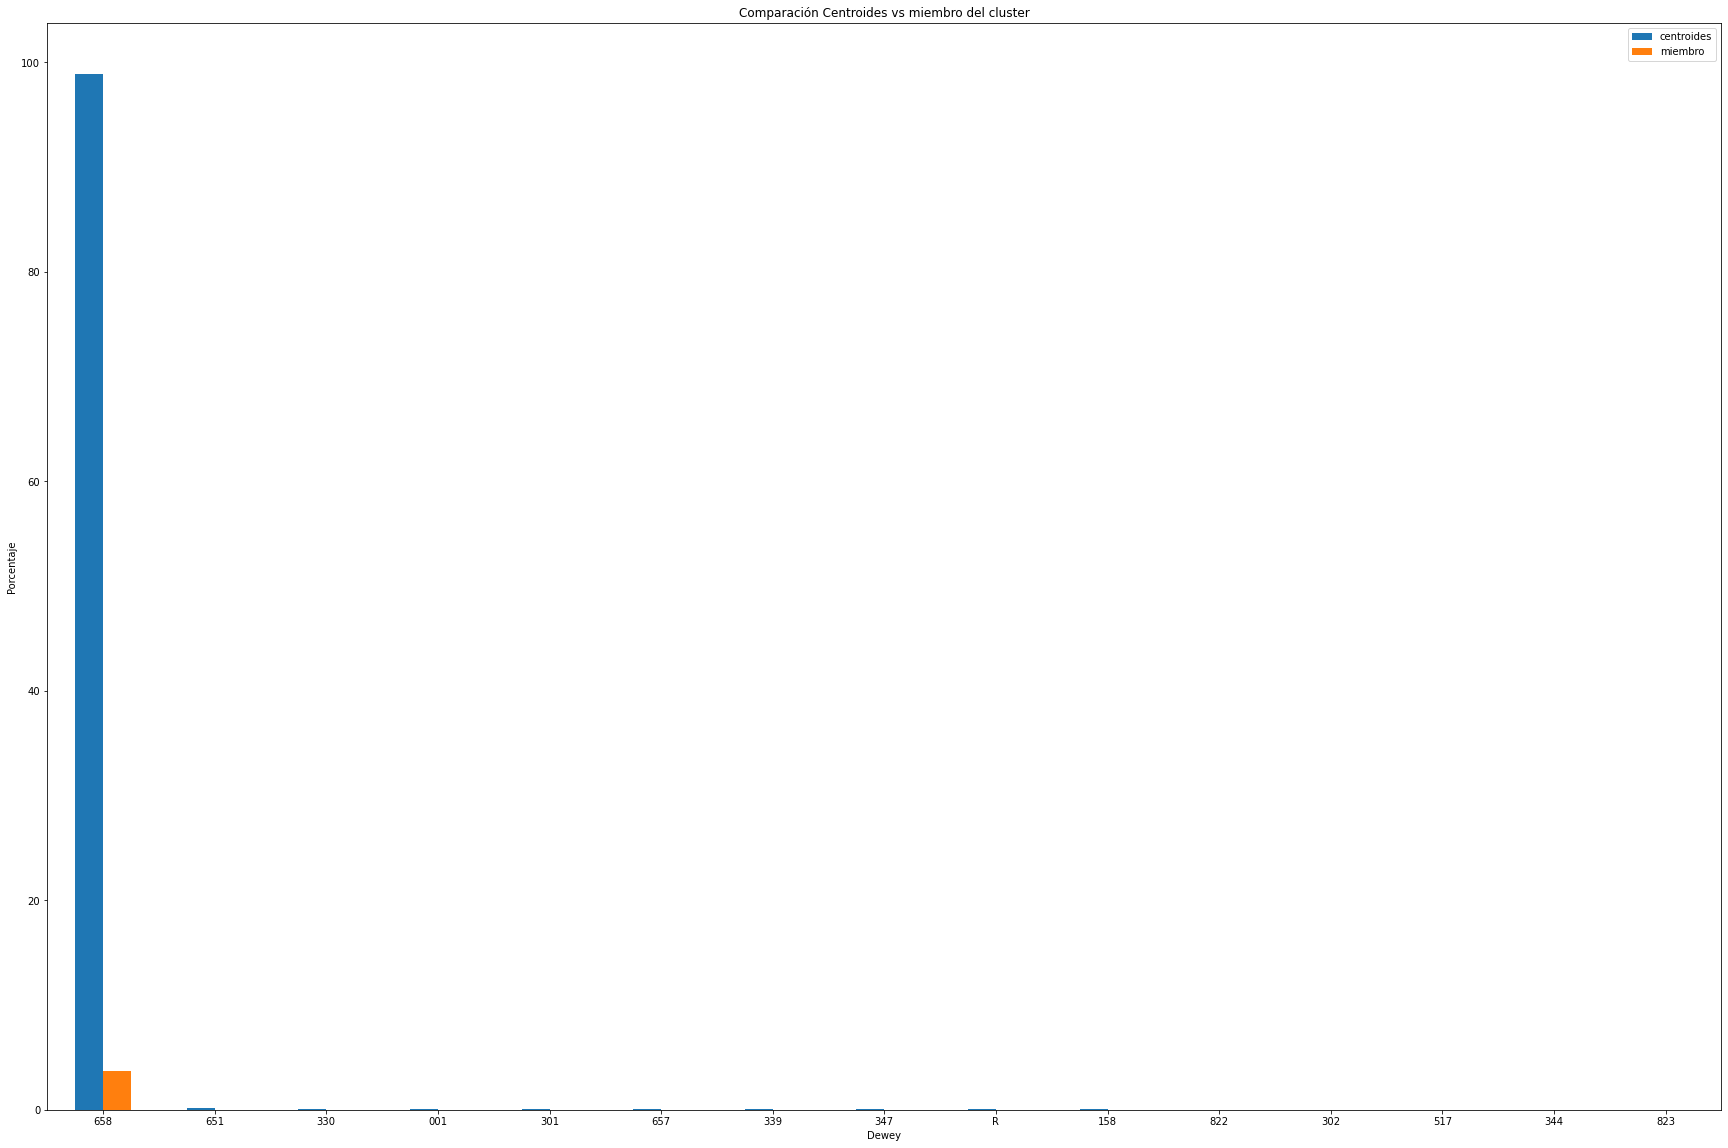

In [60]:
import matplotlib.pyplot as plt
import random
'''PREPARACION DE DATOS'''
labels = df_centroids_porcentaje.columns[:len(df_centroids_porcentaje.columns)-2]

#cluster_de_interes = int(input('Por favor ingrese numero del cluster del que desea ver la informacion: '))
cluster_de_interes = 1
num_deweys = 15

# Tomar unicamente los 10 Deweys mas importantes del cluster de interes
df_cluster_interes = df_centroids_porcentaje.loc[[cluster_de_interes]].drop(labels = 'Sum', axis = 1)

deweys_importantes = []
df_temp = df_cluster_interes.copy()

for i in range(0, num_deweys):
    maxvalueIndexLabel = df_temp.idxmax(axis = 1)
    deweys_importantes.append(maxvalueIndexLabel.values[0])
    df_temp = df_temp.drop(labels = maxvalueIndexLabel.values, axis = 1)

df_cluster_interes = df_cluster_interes.filter(items=deweys_importantes)
display(df_cluster_interes)

# Tomar unicamente los 10 Deweys mas importantes del usuario a comparar
#usuario_interes = random.randint(0,len())
df_usuario_interes = df_pesos_usuarios_porcentaje.loc[df_pesos_usuarios_porcentaje['cluster'] == cluster_de_interes].filter(items=deweys_importantes)
display(df_usuario_interes)

'''GRAFICA'''

#Datos de los centroides de un cluster (%) sin la columns de sum
temp_centroids = df_cluster_interes.iloc[0]


#Datos del primer miembro del cluster anterior (%) sin la columna de cluster ni de sum
temp_miembro = df_usuario_interes.iloc[0]

index = df_cluster_interes.columns

df_plot = pd.DataFrame({'centroides':temp_centroids, 'miembro':temp_miembro}, index=index)

ax = df_plot.plot.bar(rot=0, figsize=(30, 20), title="Comparación Centroides vs miembro del cluster")
ax.set_ylabel('Porcentaje')
ax.set_xlabel("Dewey")